# Numerical Orbit Propagation with Scipy: Tuning the Error and Performance

## Introduction

In the [first installment](https://satmad.readthedocs.io/en/latest/examples/analysis/num_prop_performance_1.html)
we introduced the basics of numerical orbit propagation and the use of existing
[ODE solvers in Scipy](https://docs.scipy.org/doc/scipy/reference/integrate.html) for that purpose.
We also compared the various solvers and has shown that DOP853 provides the best energy conservation
(implicitly, accuracy in position) with the best runtime duration performance.
In this installment we are going to look at how to choose the error tolerances and the actual impact
in accuracy in position and velocity, which is what most projects are interested in.

The analysis setup is very similar to the previous installment: start a near-circular, Low-Earth-Orbit (LEO)
satellite, propagate it with various settings and check the results. As the conservation of energy would imply
high positional accuracy, we will start directly with the DOP853 case which has good energy performance.
This time, the variable parameter is the relative tolerance (`rtol`) for a given (low) absolute tolerance value
(`atol`).


In [5]:
from astropy import units as u
from satmad.propagation.numerical_propagators import ODESolverType
from satmad.propagation.sgp4_propagator import SGP4Propagator
from satmad.propagation.tle import TLE
from satmad.propagation.tests.num_prop_analysis.num_prop_analysis_engine import propagation_engine

name = "RASAT"
line1 = "1 37791U 11044D   18198.20691930 -.00000011  00000-0  70120-5 0  9992"
line2 = "2 37791  98.1275 290.4108 0021116 321.0704  38.8990 14.64672859369594"

tle = TLE.from_tle(line1, line2, name)

rv_init = SGP4Propagator().propagate(tle, tle.epoch)

stepsize = 120 * u.s
solver_type = ODESolverType.DOP853
rtols = [3e-14, 1e-11, 1e-9, 1e-7, 1e-5]
atol = 1e-14
init_time_offset = 0 * u.day
duration = 3.0 * u.day

# run propagation and get truth trajectory
truth_traj = propagation_engine(
    rv_init,
    stepsize,
    ODESolverType.DOP853,
    init_time_offset,
    duration,
    rtol=3e-14,
    atol=1e-15,
)

## Relative Error Tolerance or the Concept of "Truth" (Where There is None)

The next step is to define the "true" trajectory. In our case, we will consider the solution with the lowest absolute
and relative tolerance as the "truth". In theory, for a numerical method,
the lower the tolerances, the lower the error. As the tolerance goes to zero, so does the error. In reality, numerical
errors introduced by a finite precision computer results in an "optimally low" tolerance to achieve the minimum error.
For a lower tolerance, numerical errors from round-off and truncation dominate and increase the overall error. For
higher tolerances, the ODE solver runs faster, but with a higher level of error.

For many problems that require a numerical ODE solver, an exact analytical solution is not possible, therefore a direct
testing of the accuracy against the "truth" cannot be carried out. For the two-body case, we do have this luxury, though
the primary aim of this analysis is to use this simple example and show the basic steps of analysing ODE solvers for
numerical orbit propagation. In reality, for most applications, the force model would have been much more complicated,
with no analytical solution to verify the results against.


In [6]:
from satmad.propagation.tests.num_prop_analysis.num_prop_analysis_engine import analyse_pos_along_trajectory

cases = {}
type(cases)

# run all cases
for rtol in rtols:
    name = str(rtol)

    analyse_pos_along_trajectory(
        truth_traj,
        cases,
        name,
        rv_init,
        stepsize,
        solver_type,
        init_time_offset,
        duration,
        rtol,
        atol,
    )

**** Case: 3e-14 ****
Runtime: 1.4294 s seconds
max pos diff: 1.0449409694321218e-05 m
**** Case: 1e-11 ****
Runtime: 0.7465 s seconds
max pos diff: 0.009258796973546233 m
**** Case: 1e-09 ****
Runtime: 0.4370 s seconds
max pos diff: 2.2980054303751265 m
**** Case: 1e-07 ****
Runtime: 0.3245 s seconds
max pos diff: 509.48816869878 m
**** Case: 1e-05 ****
Runtime: 0.1985 s seconds
max pos diff: 111797.91643777468 m


The next step runs the propagator for each `rtol` value and compares it against the "truth" trajectory, marking the
difference as well as the propagation runtime. The printed results show two clear conclusions: The lower the tolerance,
the slower but more accurate the propagation is. However, plotting the results help us understand them better.

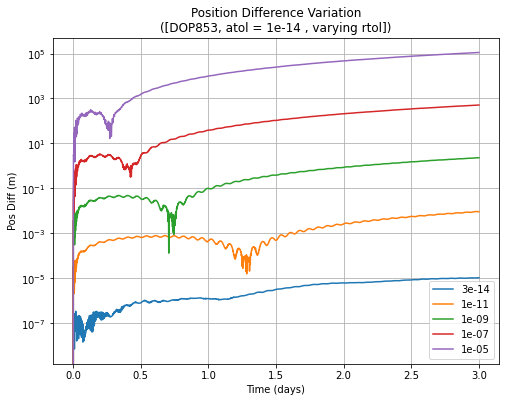

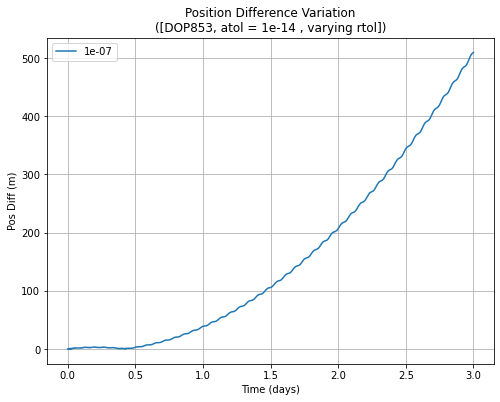

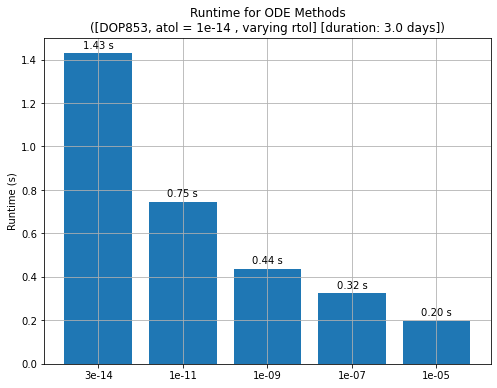

In [7]:
from satmad.propagation.tests.num_prop_analysis.num_prop_analysis_engine import plot_pos_diff, plot_runtimes

session_name = f"[DOP853, atol = {atol} , varying rtol]"

# Plot pos differences
plot_pos_diff(cases, title=session_name, logscale_plot=True)

# Plot runtime for one case to see its behaviour
plot_pos_diff({"1e-07": cases["1e-07"]}, title=f"{session_name}", logscale_plot=False)

# Plot runtimes
plot_runtimes(
    cases,
    title=f"{session_name} [duration: {duration.to_value(u.day)} days]",
    logscale_plot=False,
)

Over the propagation duration of only 3 days, the higher tolerance methods accumulated significant errors. For most
applications, meter level accuracy or better would be required with for more complicated force models. However, the
first plot shows (in log scale) that the errors exceed this level for `1e-07` and `1e-05` relative error tolerance
(`rtol`) levels. The behaviour of the `1e-07` case is shown in the next plot, which shows a clear quadratic increase.
To summarise, it is possible to estimate the errors for a requirement of 7 days or 30 days for a given `rtol` and `atol`
using this quadratic relationship. Obviously, for an orbit with different eccentricity or another near-circular orbit
with a different semi-major axis, the level of accuracy corresponding to the tolerances would change, but the basic
quadratic relationship would still persist.

In this case, to obtain meter level accuracy after 3 days would require a `rtol` of about 1e-09, whereas after 30 days
(10 times the propagation duration), the errors would increase by 100, therefore a `rtol` of 1e-11 would have been
required.

Finally, the runtimes increase significantly with the lower tolerances. Therefore it is critical to find a good
compromise between the required accuracy and the runtime. While the error increases quadratically with propagation
duration, the runtime increases linearly.

## Absolute Error Tolerance

Now that we have established the impact of `rtol` on accuracy and performance, we can run the same analysis for another
`atol` and see the impact.

**** Case: 3e-14 ****
Runtime: 1.1280 s seconds
max pos diff: 8.420170787606152e-05 m
**** Case: 1e-11 ****
Runtime: 0.7327 s seconds
max pos diff: 0.0068047805181029155 m
**** Case: 1e-09 ****
Runtime: 0.4408 s seconds
max pos diff: 2.1278298678823484 m
**** Case: 1e-07 ****
Runtime: 0.2905 s seconds
max pos diff: 509.1592260293927 m
**** Case: 1e-05 ****
Runtime: 0.1882 s seconds
max pos diff: 111797.01530840389 m


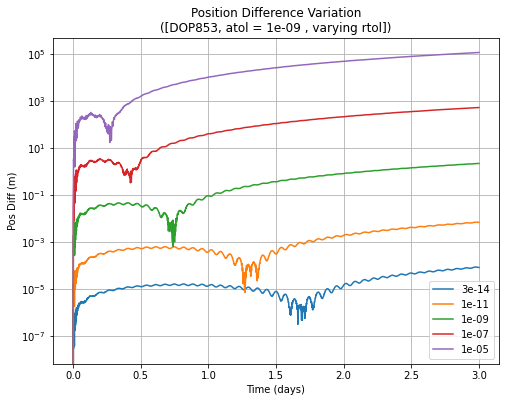

In [8]:
rtols = [3e-14, 1e-11, 1e-9, 1e-7, 1e-5]
atol = 1e-07

cases = {}
type(cases)

# run all cases
for rtol in rtols:
    name = str(rtol)
    # rtol = atol

    analyse_pos_along_trajectory(
        truth_traj,
        cases,
        name,
        rv_init,
        stepsize,
        solver_type,
        init_time_offset,
        duration,
        rtol,
        atol,
    )

session_name = f"[DOP853, atol = {atol} , varying rtol]"

# Plot pos diff differences
plot_pos_diff(cases, title=session_name, logscale_plot=True)

This time we run the same analysis, but with an `atol` of 1e-07 instead of the very low 1e-14 of the previous case.
Comparing the two results, `atol` does have an impact on the runtime and the accuracy of the lower values of `rtol`,
but the higher `rtol` values (from around 1e-09), the impact is small. In other words, even for the very low levels of
`rtol`, the achievable accuracy is limited by the high `atol` value. Similar levels of accuracy for these two cases
yield similar runtimes. To summarise, for high accuracy applications, low levels of `rtol` and `atol` are required and
they both need to be tuned for the exact requirements.

In this installment of the series, we have analysed the impact of absolute and relative tolerances on the accuracy and
shown the behaviour of error as well as runtime with the propagation duration. In the
[third installment](https://github.com/egemenimre/satmad/blob/master/docs/examples/analysis/num_prop_performance_3.ipynb)
of this series we will investigate the performance for highly eccentric orbits.

The `main` for this analysis is
[here in Github](https://github.com/egemenimre/satmad/blob/master/satmad/propagation/tests/num_prop_analysis/num_prop_analysis_accuracy.py)
for you to play with the results and change the analysis cases.